In [1]:
import argparse
import numpy as np
import pandas as pd
import pickle
import ast, os, sys
import neuroglancer
import matplotlib
import cv2
from skimage import img_as_ubyte
from matplotlib import pyplot as plt

In [2]:
PATH = '/home/eddyod/programming/pipeline_utility'
sys.path.append(PATH)
from utilities.contour_utilities import get_contours_from_annotations, add_structure_to_neuroglancer
neuroglancer.set_server_bind_address(bind_port='33645')

Connecting dklab@192.168.1.12:3306


In [23]:
DIR = '/net/birdstore/Active_Atlas_Data/data_root/CSHL_volumes'
ATLASPATH = os.path.join(DIR, 'atlasV8/mean_shapes')
contourpath = os.path.join(DIR, 'volume_colored.npy')
#contourpath = os.path.join('/home/eddyod/programming/pipeline_utility/neuroglancer', 'aligned_moving_instance.npy')
contour = np.load(contourpath)

In [ ]:
contour = img_as_ubyte(contour)

In [24]:
contour.dtype, contour.shape, np.median(contour), np.mean(contour)

(dtype('uint8'), (279, 1105, 1508), 0.0, 0.19229973160761016)

In [ ]:
M = np.median(contour)
keep_mask = contour==M
vm = np.where(contour>M,0,1)
vm[keep_mask] = M
vm = vm.astype(np.uint8)
vm.dtype, vm.shape

In [11]:
#ng_structure_volume = structure_volumes[0]
vm = np.swapaxes(ng_structure_volume,0,2)
#vol_m = np.swapaxes(vm, 0,1)
vm.shape, vm.dtype

((2301, 1092, 145), dtype('uint8'))

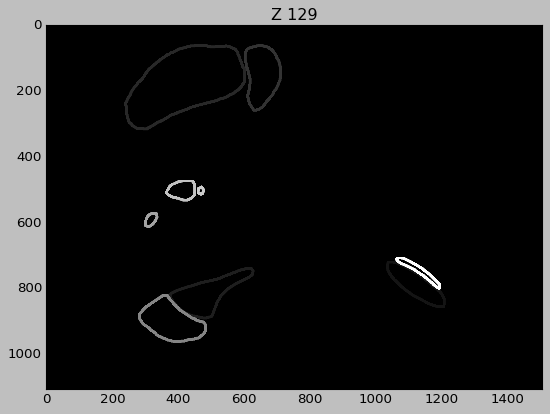

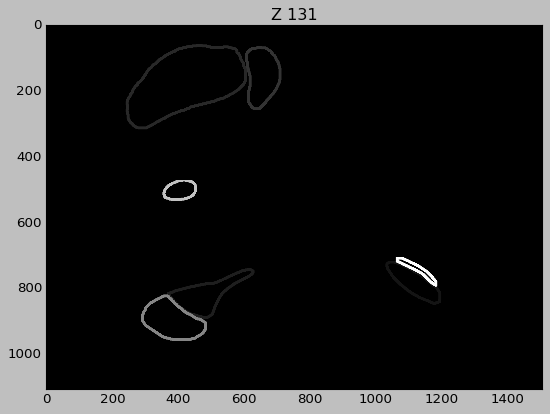

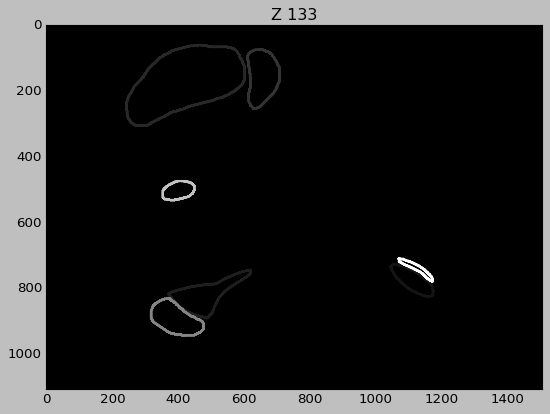

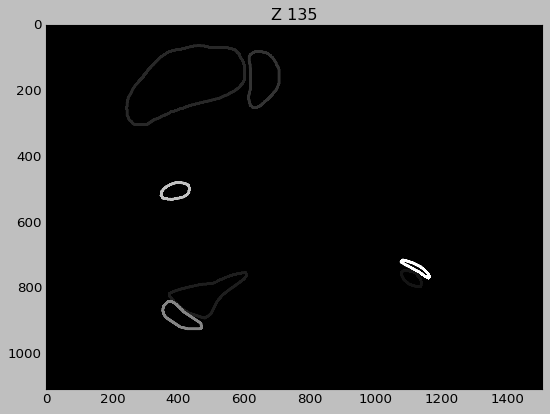

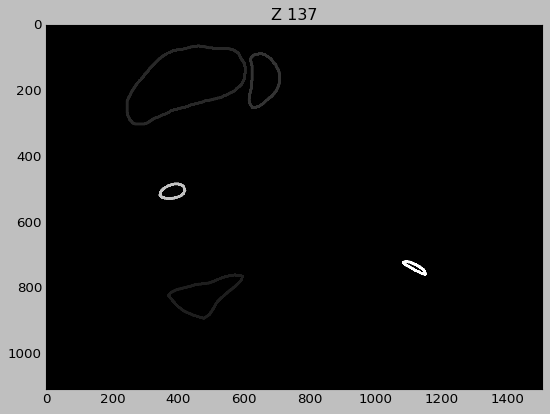

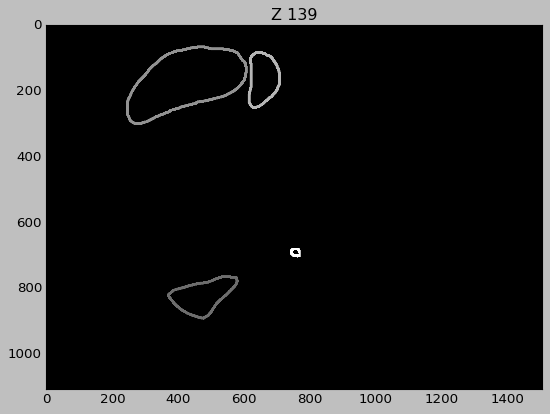

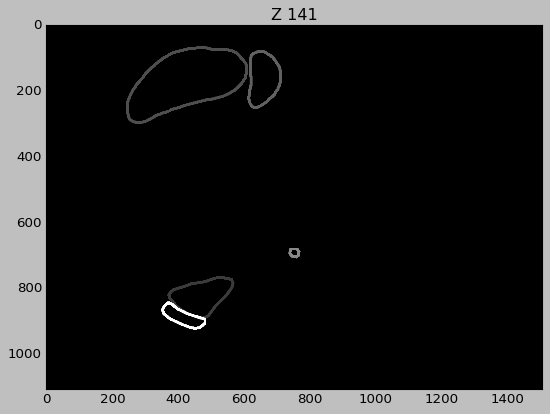

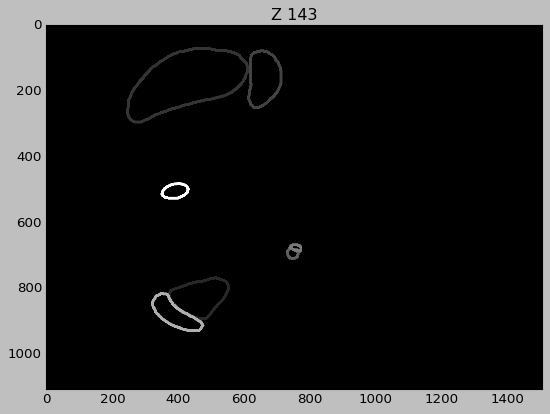

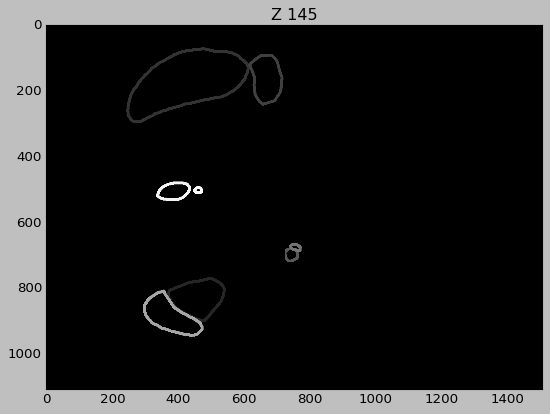

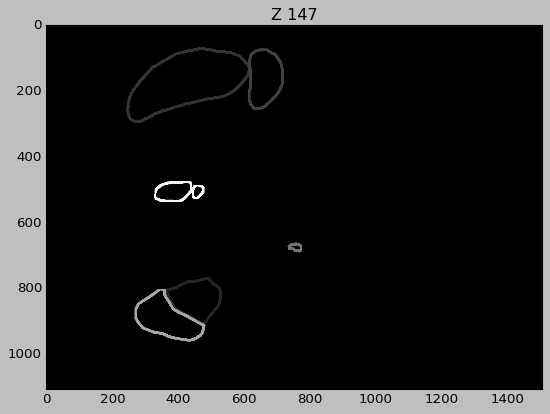

In [25]:
arr = np.swapaxes(contour,0,2)
limit = 10
start = (arr.shape[2] // 2) - limit
end = start + limit * 2
nrows = end - start
ncols = 1
plt.style.use('classic')
for i in range(start, end, 2):
    plt.title('Z {}'.format(i))
    plt.imshow(arr[:,:,i].T, cmap="gray")
    plt.show()

In [13]:
csvfile = os.path.join(PATH, 'neuroglancer/contours','MD589_annotation_contours.csv')
MD589_annotations = pd.read_csv(csvfile)
MD589_annotations.head()

,Unnamed: 0,class,creator,edits,filename,id,label_position,name,orientation,parent_structure,resolution,section,side,side_manually_assigned,time_created,type,vertices
0,100157269992733,contour,yuncong,"[{'username': 'yuncong', 'timestamp': '0915201...",MD589-IHC69-2015.07.31-02.07.15_MD589_1_0205,100157269992733,[15317.43823807 12578.50401305],VCA,sagittal,[],raw,367,R,False,9152016033619,confirmed,[[15450.64315379 13041.15143737]\n [15292.3766...
1,100472025966132,contour,yuncong,"[{'username': 'yuncong', 'timestamp': '0912201...",MD589-N51-2015.07.30-19.28.17_MD589_2_0152,100472025966132,[25707.69102116 17933.27685287],IO,sagittal,[],raw,260,R,False,9122016211223,confirmed,[[25199.46145603 17916.30221869]\n [24976.1090...
2,10063296125941,contour,yuncong,"[{'username': 'yuncong', 'timestamp': '0915201...",MD589-N55-2015.07.30-19.49.42_MD589_3_0165,10063296125941,[28722.35048812 16712.94413081],LRt,sagittal,[],raw,286,R,False,9152016024654,confirmed,[[29069.49187508 17203.67921491]\n [28909.8937...
3,101105413939417,contour,yuncong,"[{'username': 'yuncong', 'timestamp': '0915201...",MD589-N54-2015.07.30-19.44.32_MD589_1_0160,101105413939417,[28529.80042174 15814.38685363],LRt,sagittal,[],raw,276,R,False,9152016024654,confirmed,[[29219.12776439 16422.80664145]\n [29084.8059...
4,101214741356495,contour,yuncong,"[{'username': 'yuncong', 'timestamp': '0531201...",MD589-N37-2015.07.30-18.32.51_MD589_1_0109,101214741356495,[22896.75853307 6674.71411486],SC,sagittal,[],raw,202,S,False,5312018021355,intersected,[[21584.44352233 7847.78193722]\n [21497.5691...


In [22]:
MD589_annotations.groupby(['creator', 'name']).count()[['edits']]

edits
creator name       
lauren  SNC       1
        SNR       7
nicole  Sp5C      3
        Sp5I     11
        Sp5O     11
...             ...
yuncong VCP      49
        VLL      70
        VTA      10
        VTg       5
        X        30

[70 rows x 1 columns]

In [ ]:
hand_annotations.head(4)

In [ ]:
animal = 'atlasV7'
target_structure = 'Tz'
str_contours_annotation, first_sec, last_sec = get_contours_from_annotations(animal, target_structure, hand_annotations, densify=0)

In [ ]:
first_sec, last_sec

In [ ]:
dimensions = neuroglancer.CoordinateSpace(
    names=['x', 'y', 'z'],
    units='nm',
    scales=[10, 10, 10])

viewer = neuroglancer.Viewer()
with viewer.txn() as s:
    s.dimensions = dimensions
    s.layers['Altas'] = neuroglancer.ImageLayer(
        source=neuroglancer.LocalVolume(
            data=contour,
            dimensions=neuroglancer.CoordinateSpace(
                names=['x', 'y', 'z'],
                units=['nm','nm','nm'],
                scales=[5, 5, 5]),
            voxel_offset=(0, 0, 0),
        ),
        shader="""
#uicontrol float min slider(min=0, max=1, default=0)
#uicontrol float max slider(min=0, max=1, default=1)
#uicontrol float invert slider(min=0, max=1, default=0, step=1)
#uicontrol float brightness slider(min=-1, max=1)
#uicontrol float contrast slider(min=-3, max=3, step=0.01)
void main() {
  float pix_val = toNormalized(getDataValue());
  if(pix_val < min){
  	pix_val = 0.0;
  }
  if(pix_val > max){
    pix_val = 1.0;
  }

  if(invert==1.0){
  	  emitGrayscale((1.0 -(pix_val - brightness)) *
       exp(contrast));
  }
  else{
    emitGrayscale((pix_val + brightness) *
                  exp(contrast));
  }

}

""")
print(viewer)

In [4]:
csvfile = os.path.join(PATH, 'neuroglancer/contours', 'hand_annotations.csv')
hand_annotations = pd.read_csv(csvfile)
hand_annotations['vertices'] = hand_annotations['vertices'].apply(lambda x: ast.literal_eval(x))
animal = 'MD589'
color_codes = {"3N": 3, "4N": 4, "5N": 5, "6N": 6, "Tz": 24, "VCA_L": 25, "VCA_R": 25}
viewer = neuroglancer.Viewer()
# Sets 'Image' layer to be MD585 prep2 images from S3
with viewer.txn() as s:
    s.layers[animal] = neuroglancer.ImageLayer(source='precomputed://https://mousebrainatlas-datajoint-jp2k.s3.amazonaws.com/precomputed/'+animal+'_fullres')
    s.layout = 'xy' # '3d'/'4panel'/'xy'
print(viewer)

http://127.0.0.1:33645/v/28b9bfb6719c98fd063c134bfbd1c542e9fda826/


In [ ]:
neuroglancer.stop()

In [5]:
structure_volumes = []
offsets = []
structures = ['3N', '4N', '5N', '6N', 'Tz']
for target_structure in structures:
    color = color_codes[target_structure]
    str_contours_annotation, first_sec, last_sec = get_contours_from_annotations(animal, target_structure, hand_annotations, densify=0)
    ng_structure_volume, xyz_offsets = add_structure_to_neuroglancer(viewer, str_contours_annotation, target_structure, animal, first_sec, last_sec, \
                                                        color_radius=2, xy_ng_resolution_um=5, threshold=1, color=color, \
                                                        solid_volume=False, no_offset_big_volume=True, save_results=False, \
                                                        return_with_offsets=True, add_to_ng=True, human_annotation=True )
    structure_volumes.append(ng_structure_volume)
    offsets.append(xyz_offsets)

last_sec 237
ng_section_min 92
str_contour 1
last_sec 240
ng_section_min 92
str_contour 1
last_sec 310
ng_section_min 92
str_contour 1
last_sec 251
ng_section_min 92
str_contour 1
last_sec 275
ng_section_min 92
str_contour 1


In [ ]:
print(viewer)

In [6]:
structures = ['3N', '4N', '5N', '6N', 'Tz']
for structure, volume, offset in zip(structures, structure_volumes,offsets):
    vm = np.swapaxes(volume,0,2)
    print(structure, vm.shape, offset)

3N (2301, 1092, 145) [2004, 805, 119]
4N (2324, 1087, 148) [2008, 830, 116]
5N (2256, 1502, 218) [1541, 1054, 58]
6N (2421, 1376, 159) [2176, 1117, 113]
Tz (2409, 1827, 183) [1620, 1278, 108]
